In [1]:
#Zainstalowanie odpowiednich pakietów
import sys
!{sys.executable} -m pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
#Zaimportowanie odpowiednich pakietów
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

In [3]:
#Wczytanie danych z pliku CSV
df = pd.read_csv('inpatientCharges.csv')

In [4]:
#Sprawdzenie, czy plik wczytał się poprawnie
df.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,$32963.07,$5777.24,$4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,$15131.85,$5787.57,$4976.71
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,$37560.37,$5434.95,$4453.79
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,$13998.28,$5417.56,$4129.16
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,$31633.27,$5658.33,$4851.44


In [5]:
#Sprawdzenie, ile stanów zawartych jest w bazie 
df['Provider State'].nunique()

51

In [6]:
#Sprawdzanie typów danych w kolumnach; próba rozwiązania problemu ze stringami na przykładzie jednej kolumny
df[' Average Covered Charges '].dtype
type(df[' Average Covered Charges '][0])
df[' Average Covered Charges '].map(type).unique()
df[' Average Covered Charges '] = df[' Average Covered Charges '].apply(lambda x: x.split('$')[1])
df[' Average Covered Charges '].dtype
df[' Average Covered Charges '] = df[' Average Covered Charges '].astype(float)

In [7]:
df[df[' Average Covered Charges '].isna()==True].shape #Nie będzie problemu z NaN, bo nie ma takich wartości

(0, 12)

In [8]:
#Zaaplikowanie rozwiązania do wszystkich kolumn wymagających konwersji
df[' Total Discharges '] = df[' Total Discharges '].astype(float)
df[df[' Total Discharges '].isna()==True].shape

(0, 12)

In [9]:
df[' Average Total Payments '] = df[' Average Total Payments '].apply(lambda x: x.split('$')[1])
df[' Average Total Payments '] = df[' Average Total Payments '].astype(float)
df[df[' Average Total Payments '].isna()==True].shape

(0, 12)

In [ ]:
df['Average Medicare Payments'] = df['Average Medicare Payments'].apply(lambda x: x.split('$')[1])
df['Average Medicare Payments'] = df['Average Medicare Payments'].astype(float)
df[df['Average Medicare Payments'].isna()==True].shape

In [39]:
#Stworzenie nowej zmiennej, która będzie pokazywała procentową wartość płatności Medicare w stosunku do całkowitych płatności
df['Medicare Payments as Percentage'] = df['Average Medicare Payments'] / df[' Average Total Payments '] * 100
df['Actual Payments as Percentage'] = df[' Average Total Payments '] / df[' Average Covered Charges '] * 100

In [42]:
#Grupowanie danych według stanów; sprawdzenie, w których stanach procentowa wartość płatności Medicare jest najwyższa i najnisza
df_stany = (
    df.groupby('Provider State')['Medicare Payments as Percentage']
      .mean()
      .sort_values(ascending=False)
      .reset_index()
)
df_stany.head()

,Provider State,Medicare Payments as Percentage
0,MD,88.894265
1,CA,88.508425
2,DC,88.432002
3,VT,87.486097
4,MA,87.252527


In [29]:
df_stany.tail()

,Provider State,Medicare Payments as Percentage
46,NV,82.700268
47,NE,82.562020
48,VA,82.135302
49,AL,81.662175
50,UT,78.570904


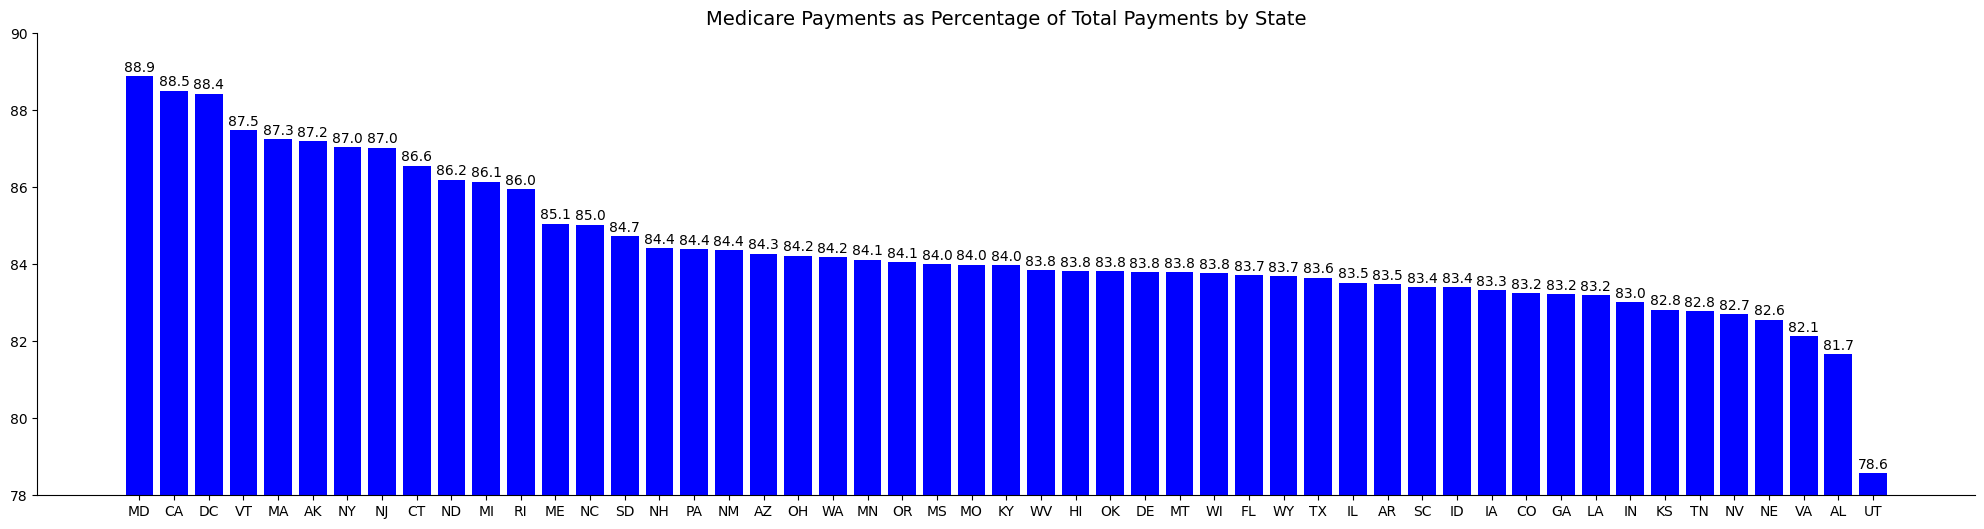

In [67]:
#Wizualizacja danych
fig = plt.figure(figsize =(25,6))
ax = plt.axes()
bars = ax.bar(df_stany['Provider State'], df_stany['Medicare Payments as Percentage'], color='blue', label='Medicare Payments as Percentage')
ax.bar_label(bars, fmt='%.1f', padding=1, fontsize=10)
ax.spines['top'].set_visible(False)    
ax.spines['right'].set_visible(False)  
ax.set_title('Medicare Payments as Percentage of Total Payments by State', fontsize=14)
ax.set_ylim(78,90)
plt.show()
#Okazuje sie, ze we wszystkich stanach wartosc pokrycia przez Medicare jest dosc podobna

In [ ]:
#Sprawdzamy teraz po chorobach – dla jakich rachunek wystawiony przez szpital bedzie najbardziej zawyzony?
df_choroby = (
    df.groupby('DRG Definition')
      .mean(numeric_only=True)
      .sort_values(by='Actual Payments as Percentage', ascending=False) 
      .reset_index()  
)
df_choroby.head()
#Zrobic zeby tu nie przypisywalo sredniej tylko liste

,DRG Definition,Provider Id,Provider Zip Code,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Medicare Payments as % of Total,Medicare Payments as Percentage,Actual Payments as Percentage
0,885 - PSYCHOSES,249210.380098,46881.869494,146.383361,19929.451387,6968.721876,5864.125644,83.803437,83.803437,44.798540
1,603 - CELLULITIS W/O MCC,258565.649092,49704.816174,50.193801,18968.728304,5798.941044,4678.978529,80.117983,80.117983,38.141520
2,897 - ALCOHOL/DRUG ABUSE OR DEPENDENCE W/O REH...,254257.245033,43531.662252,35.248344,17589.094448,4949.907307,3999.917704,80.062443,80.062443,37.399618
3,292 - HEART FAILURE & SHOCK W CC,258867.616661,50001.124958,75.190654,23517.980789,6957.831656,6132.341256,87.764544,87.764544,37.206502
4,871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...,255988.718350,50127.700569,113.467994,45934.993962,13238.823385,12169.041668,91.749599,91.749599,37.103909


In [76]:
df_choroby.tail()

,DRG Definition,Provider Id,Provider Zip Code,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Medicare Payments as % of Total,Medicare Payments as Percentage,Actual Payments as Percentage
95,246 - PERC CARDIOVASC PROC W DRUG-ELUTING STEN...,247694.097056,51787.689204,29.557252,96348.806707,23326.339019,21052.854929,90.538174,90.538174,28.168943
96,"287 - CIRCULATORY DISORDERS EXCEPT AMI, W CARD...",251923.681134,50423.125579,67.083333,35230.917743,7736.450422,6334.245637,81.606975,81.606975,26.375290
97,251 - PERC CARDIOVASC PROC W/O CORONARY ARTERY...,250338.694635,49392.313618,39.316369,62044.069464,13315.209477,11445.416492,86.477977,86.477977,25.453424
98,249 - PERC CARDIOVASC PROC W NON-DRUG-ELUTING ...,249496.642932,48182.253403,34.185340,59052.082084,12593.510618,10621.455466,85.195549,85.195549,25.190290
99,247 - PERC CARDIOVASC PROC W DRUG-ELUTING STEN...,249462.046165,52887.019886,76.897727,66737.754098,14353.519659,11770.997940,82.568139,82.568139,25.178392


In [77]:
df_choroby_wybrane = pd.concat([
    df_choroby.iloc[:4],    # first 4 rows
    df_choroby.iloc[-4:]    # last 4 rows
], ignore_index=True)

In [83]:
drg_list = df_choroby_wybrane['DRG Definition'].unique()
data_to_plot = [df_choroby_wybrane.loc[df_choroby_wybrane['DRG Definition'] == drg, 
                                       ' Average Covered Charges '] 
                for drg in drg_list]

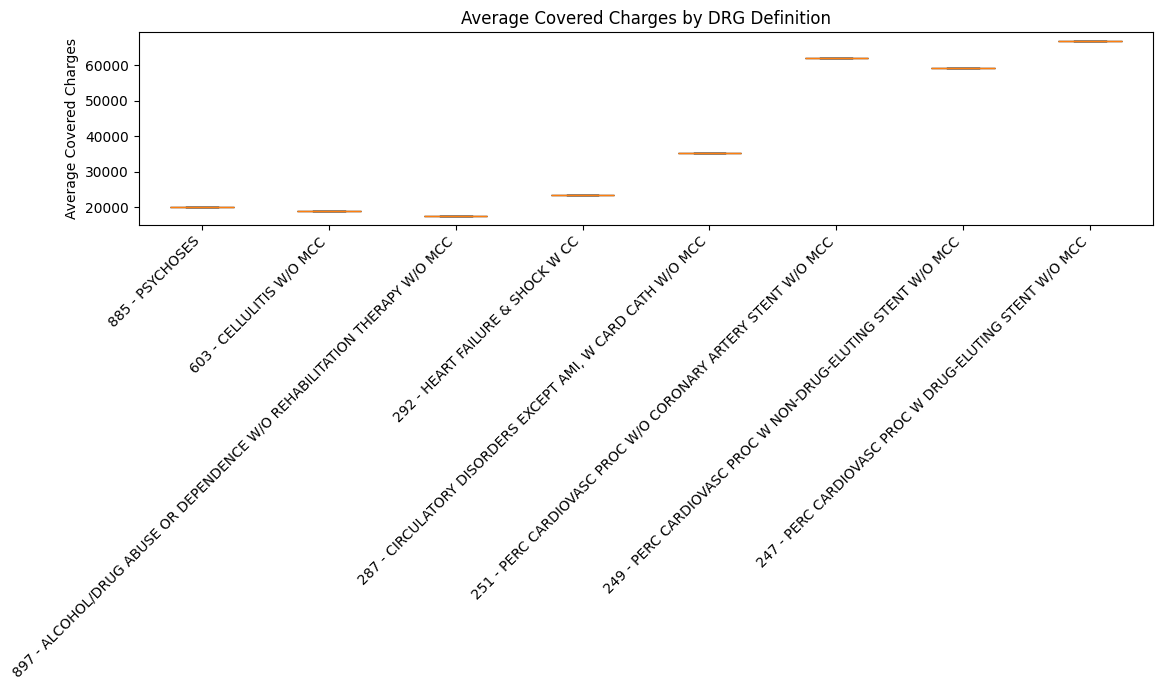

In [84]:
# Plot
fig, ax = plt.subplots(figsize=(12, 7))
ax.boxplot(data_to_plot, patch_artist=True)

# Set x-axis labels
ax.set_xticklabels(drg_list, rotation=45, ha='right')

# Add labels and title
ax.set_ylabel('Average Covered Charges')
ax.set_title('Average Covered Charges by DRG Definition')

plt.tight_layout()
plt.show()